In [1]:
%load_ext autoreload
%autoreload 2

import torch 
import pyro
import inspect

c:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from PFNExperiments.LinearRegression.GenerativeModels.GenerateData import GenerateData, check_data, check_and_plot_data
from PFNExperiments.LinearRegression.GenerativeModels.GenerateDataLM_Examples import make_lm_program_plain, make_lm_program_gamma_gamma, make_lm_program_gamma_gamma_augmented
from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code

        def multivariate_lm_return_dict(x: torch.tensor, y: torch.tensor = None) -> dict:
            
            beta_dist = pyro.distributions.Gamma(a0, b0)
            beta_var = pyro.sample("beta_var", beta_dist)
        
            sigma_squared_dist = pyro.distributions.Gamma(a1, b1)
            sigma_squared = pyro.sample("sigma_squared", sigma_squared_dist)

            beta_cov = torch.eye(x.shape[1]) * beta_var # the covariance matrix of the parameters of the linear model
            beta = pyro.sample("beta", pyro.distributions.MultivariateNormal(torch.zeros(x.shape[1]), beta_cov)) # the parameters of the linear model

            mean = torch.matmul(x, beta)

            with pyro.plate("data", x.shape[0]):
                y = pyro.sample("obs", pyro.distributions.Normal(mean, sigma_squared), obs=y)

            return {
                        "x": x,
                        "y": y,
                        "sigma_squared": sigma_squared,
                        "beta_var

100%|██████████| 1000/1000 [00:01<00:00, 921.21it/s]


Discarded 0 samples
{'X': {'mean': tensor(0.5000), 'variance': tensor(0.0834), 'min': tensor(1.2517e-06), 'max': tensor(1.0000)}, 'y': {'mean': tensor(-0.0446), 'variance': tensor(9.6585), 'min': tensor(-21.7545), 'max': tensor(22.0839)}, 'beta': {'mean': tensor([-0.0697,  0.0009, -0.0148]), 'variance': tensor([2.6259, 2.4981, 2.6376]), 'min': tensor([-6.3639, -5.0796, -5.5191]), 'max': tensor([5.8799, 7.0646, 7.4698])}}
Statistics for sigma_squared:
Mean: 2.4371519088745117
Variance: 1.1893572807312012
Min: 0.3563418686389923
Max: 6.896963119506836


Statistics for beta_var:
Mean: 2.564728021621704
Variance: 1.2801399230957031
Min: 0.4852945804595947
Max: 7.302894592285156




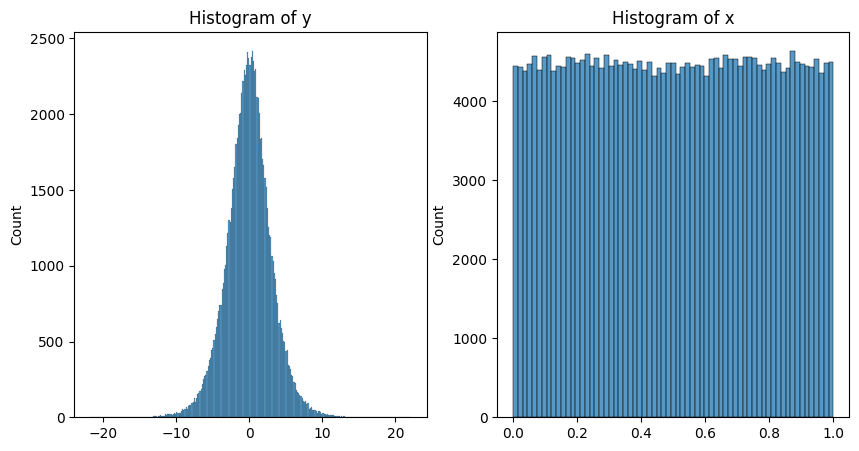

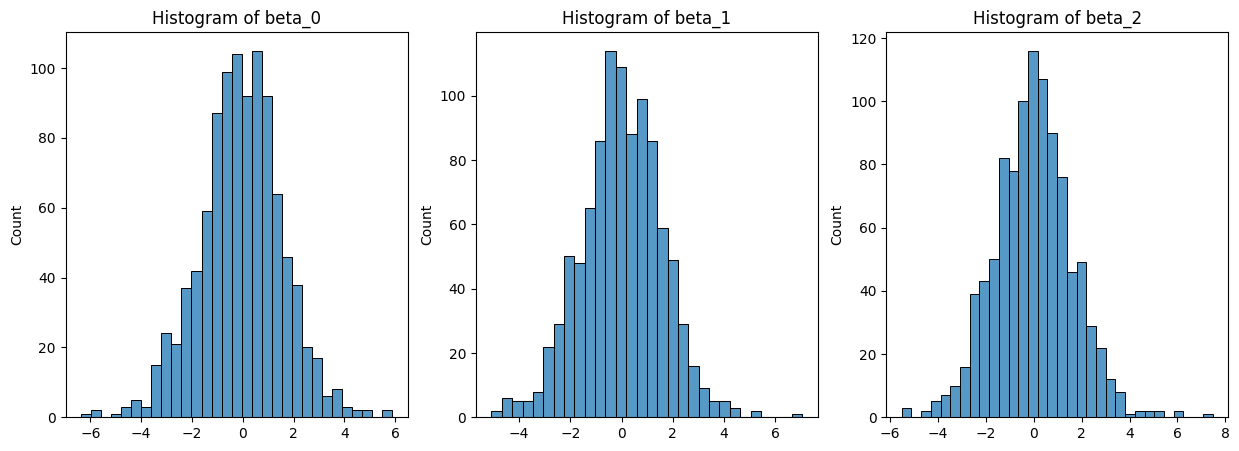

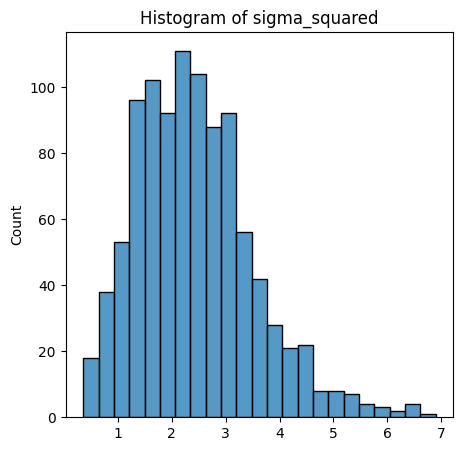

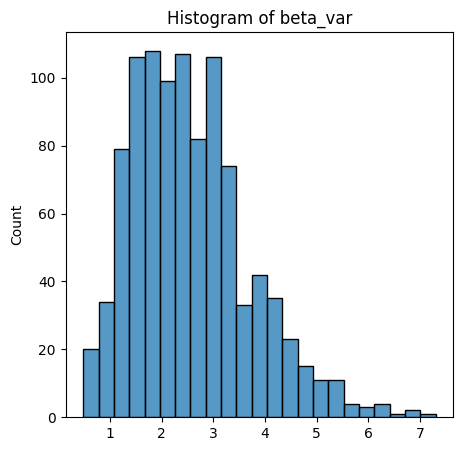

In [3]:
x_test = torch.rand(10, 5)
pprogram1 = make_lm_program_gamma_gamma()
pprogram1_y = return_only_y(pprogram1)
pprogram1
print_code(pprogram1)
generator = GenerateData(pprogram1)
generator.render_model()
_ = generator.check_model()


In [4]:
loader = generator.make_dataloaders_dynamic(
    n_batch=1000,
    
)

In [5]:
train_loader, val_loader, test_loader = loader

In [6]:
from PFNExperiments.LinearRegression.Models.Transformer import Transformer

In [7]:
batch = next(iter(train_loader))
x = batch['x']
y = batch['y']
beta = batch['beta']

In [8]:
print(x.shape)

torch.Size([256, 100, 5])


In [9]:
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

In [10]:
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

In [11]:
batch = next(iter(train_loader))
x = batch['x']
y = batch['y']
beta = batch['beta']
print(x.shape)
X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)

torch.Size([256, 100, 5])


In [12]:
def batch_to_model(batch:dict) -> torch.tensor:
    x = batch['x']
    y = batch['y']
    X_y = torch.cat([x, y.unsqueeze(-1)], dim = -1)
    return X_y

In [13]:
model = Transformer(
    n_features=6,
    seq_len=100,
    d_model=126,
    n_heads=2,
    dim_feedforward=126,
    n_layers=4,
    n_output_units_per_head=[5, 5*5, 5]
)

In [14]:
out = model(X_y)

In [15]:
mu, cov_factor, cov_diag = out

In [16]:
from PFNExperiments.Training.Trainer import Trainer, batch_to_model_lm, visualize_training_results
from PFNExperiments.Training.Losses import MSELoss_unsqueezed

from PFNExperiments.Training.EvalMetrics import mean_squared_error_torch_avg, mae_torch_avg, r2_score_torch_avg

In [17]:
from PFNExperiments.LinearRegression.Models.ModelPosterior import ModelPosteriorFullGaussian

In [18]:
nll_loss = ModelPosteriorFullGaussian(cov_reg_factor = 1e-6).negative_log_likelihood
nll_loss_avg = ModelPosteriorFullGaussian(cov_reg_factor = 1e-6).negative_log_likelihood_avg

In [19]:
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0)

In [20]:
additional_evals = {
    "loss": nll_loss_avg,
}
trainer = Trainer(
    model = model,
    optimizer=opt,
    scheduler = None,
    loss_function=nll_loss,
    trainset = train_loader,
    valset=val_loader,
    evaluation_functions= additional_evals,
    n_epochs = 10,
    early_stopping_patience = 20  
)

In [21]:
trainer.validate()

{'loss': tensor(2443.8252)}

In [22]:
r = trainer.train()

100%|██████████| 3/3 [00:07<00:00,  2.34s/it]


Epoch 0:
Training: {'loss': tensor(20.5800)}
Validation: {'loss': tensor(342.9576)}
Time: 7.500860691070557


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.10s/it]


Epoch 1:
Training: {'loss': tensor(18.3943)}
Validation: {'loss': tensor(193.5100)}
Time: 6.761072158813477


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.11s/it]


Epoch 2:
Training: {'loss': tensor(17.8639)}
Validation: {'loss': tensor(89.9411)}
Time: 6.77797794342041


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.07s/it]


Epoch 3:
Training: {'loss': tensor(14.2258)}
Validation: {'loss': tensor(107.1192)}
Time: 6.672585725784302


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


Epoch 4:
Training: {'loss': tensor(13.9715)}
Validation: {'loss': tensor(72.4438)}
Time: 6.707016229629517


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.05s/it]


Epoch 5:
Training: {'loss': tensor(14.2178)}
Validation: {'loss': tensor(22.8516)}
Time: 6.699663400650024


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.15s/it]


Epoch 6:
Training: {'loss': tensor(12.2251)}
Validation: {'loss': tensor(16.2249)}
Time: 6.8967835903167725


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.06s/it]


Epoch 7:
Training: {'loss': tensor(13.2154)}
Validation: {'loss': tensor(15.0089)}
Time: 6.667357921600342


----------------------------------------------------------------------------------------------------
Saving model


100%|██████████| 3/3 [00:06<00:00,  2.10s/it]


Epoch 8:
Training: {'loss': tensor(13.1814)}
Validation: {'loss': tensor(26.1874)}
Time: 6.872276782989502


----------------------------------------------------------------------------------------------------


100%|██████████| 3/3 [00:06<00:00,  2.04s/it]


Epoch 9:
Training: {'loss': tensor(12.2810)}
Validation: {'loss': tensor(19.6797)}
Time: 6.5927910804748535


----------------------------------------------------------------------------------------------------


In [23]:
model = trainer.model
model.eval()

Transformer(
  (mlp1): PositionwiseFeedForward(
    (w_1): Linear(in_features=6, out_features=66, bias=True)
    (w_2): Linear(in_features=66, out_features=126, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (act1): LeakyReLU(negative_slope=0.01)
  (encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=126, out_features=126, bias=True)
    )
    (linear1): Linear(in_features=126, out_features=126, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=126, out_features=126, bias=True)
    (norm1): LayerNorm((126,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((126,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
  

TypeError: 'Axes' object is not subscriptable

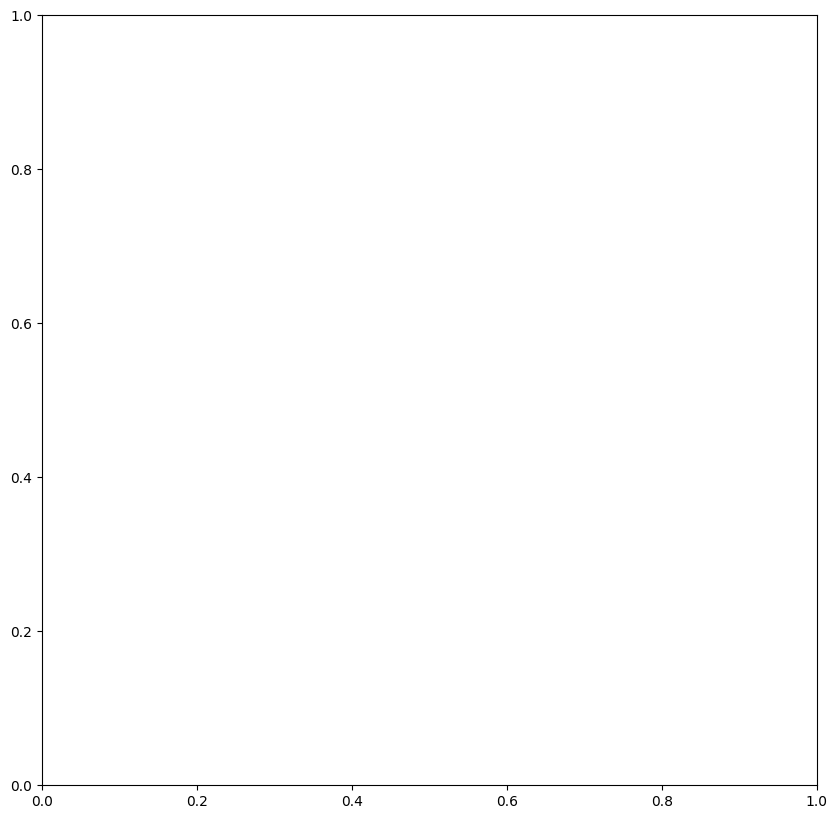

In [25]:
visualize_training_results(r, loglog=True)

In [ ]:
from PFNExperiments.LinearRegression.Models.ModelToPosterior import ModelToPosterior
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC

In [ ]:
full_model = ModelToPosterior(model, ModelPosteriorFullGaussian(cov_reg_factor = 1e-6))

In [ ]:
test_batch = next(iter(test_loader))
X_test = test_batch['x'][0]
y_test = test_batch['y'][0]

In [ ]:
from PFNExperiments.Evaluation.ComparePosteriorSamples import compare_all_metrics, marginal_plots_hist_parallel, marginal_plots_kde_together, sample_plot_2d, plot

In [ ]:
from PFNExperiments.LinearRegression.Evaluation.CompareModels import ModelComparison

In [ ]:
hmc_sampler = Hamiltionian_MC(pprogram = pprogram1, n_warmup=500, n_samples=500, kernel_kwargs = {"step_size": 1e-3, "adapt_step_size": True})

In [ ]:
comparison_model = ModelComparison(
    modelposterior=full_model,
    comparison_model=hmc_sampler
)

In [ ]:
test_batch = next(iter(test_loader))

In [ ]:
test_batch["x"].shape

torch.Size([150, 100, 5])

Sample: 100%|██████████| 1000/1000 [12:15,  1.36it/s, step size=1.00e-03, acc. prob=0.896]


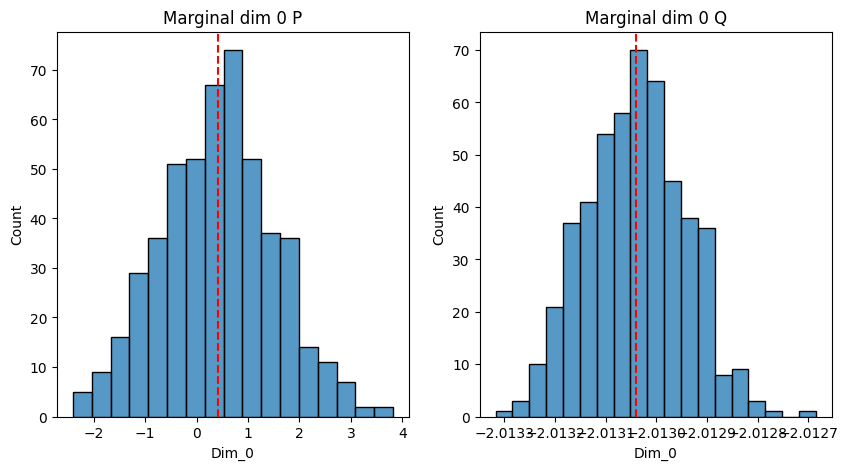

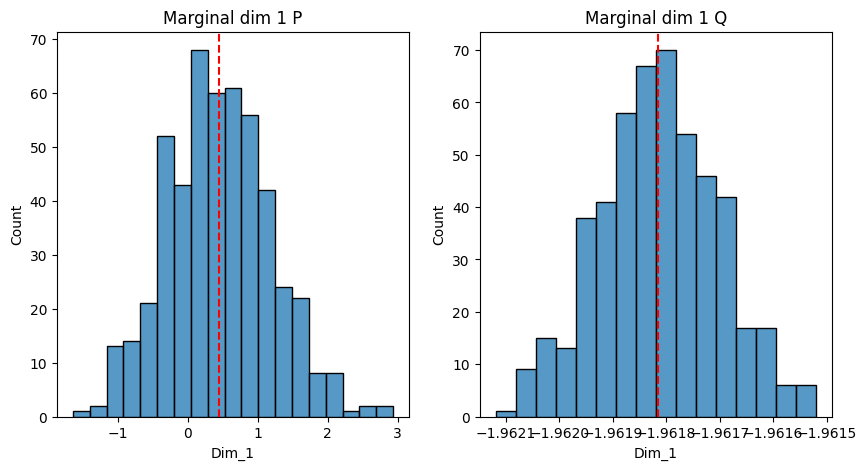

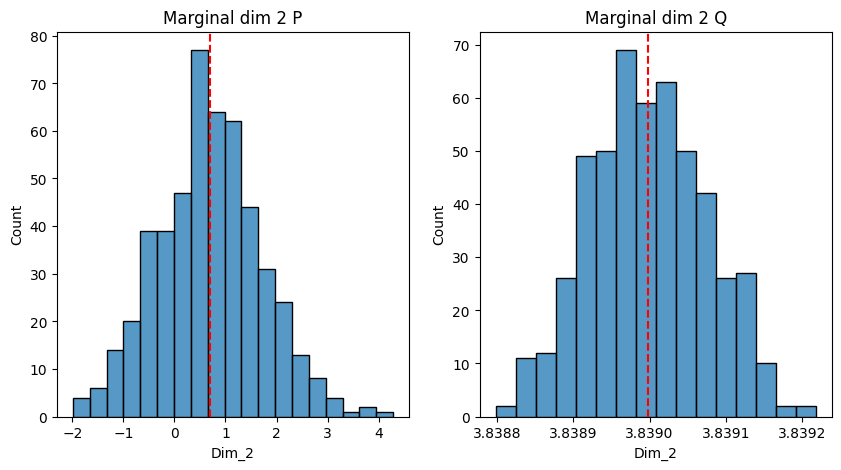

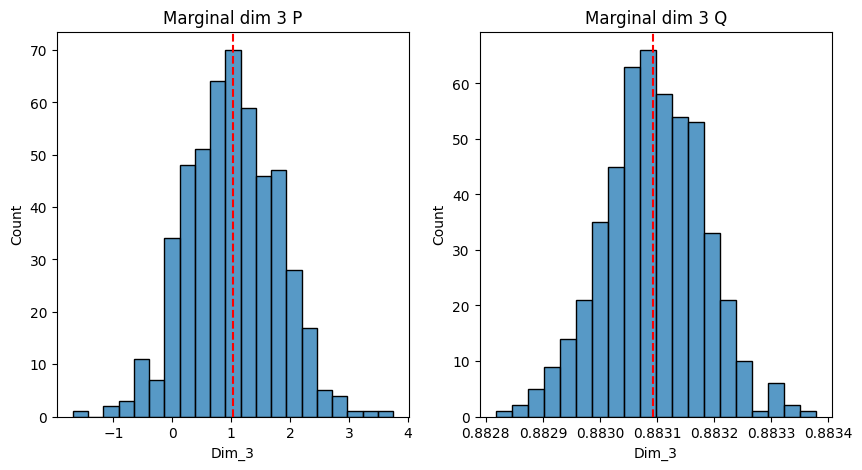

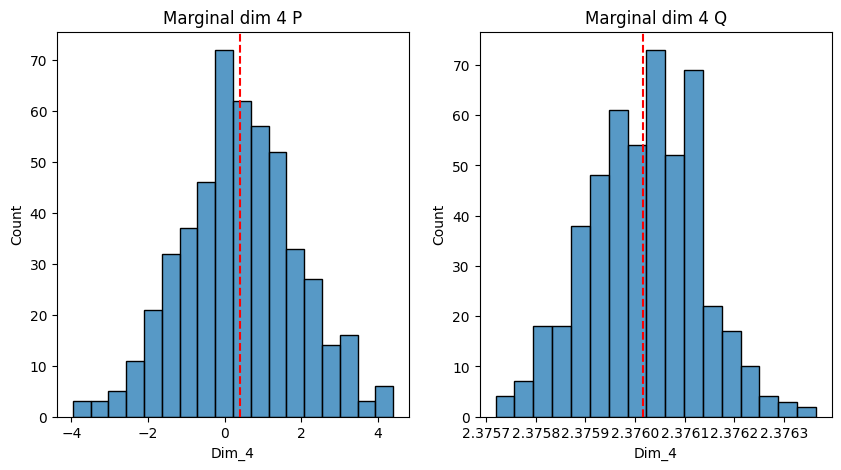

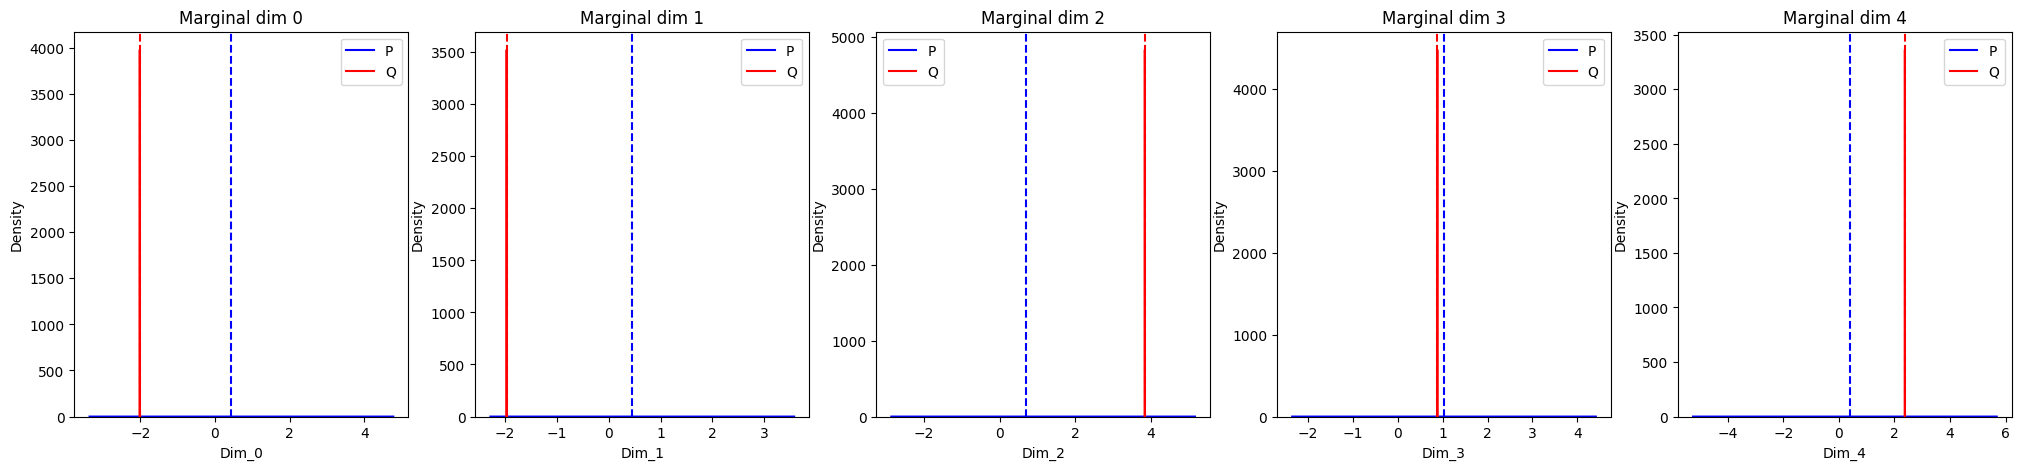

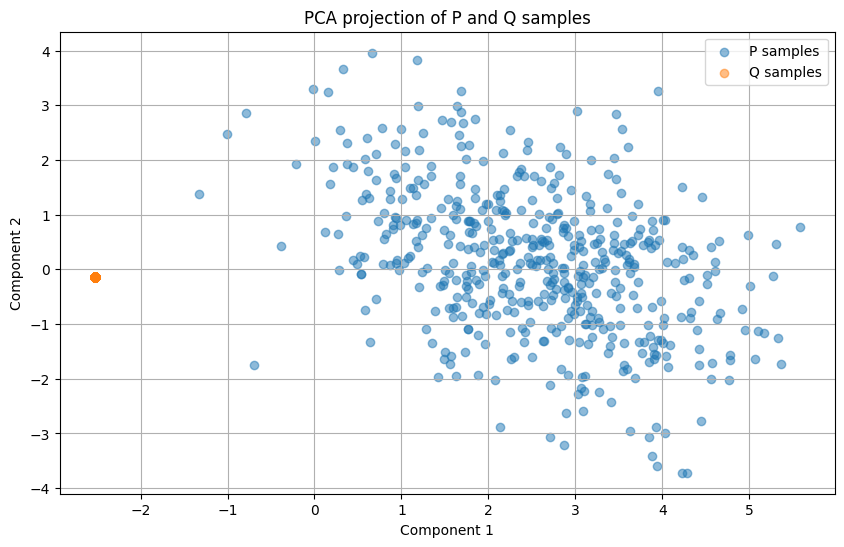

C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Evaluation\CompareModels.py:187: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  batch_metrics_std[key1] = torch.std(torch.tensor([metric[key1] for metric in batch_metrics]))
C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Evaluation\CompareModels.py:182: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  batch_metrics_std[key1][key2] = torch.std(torch.tensor([metric[key1][key2] for metric in batch_metrics]))
C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Eva

In [ ]:
r = comparison_model.compare_sample_metrics_batch(test_batch["x"][:1], test_batch["y"][:1])

In [ ]:
r[0]

[{'loss': tensor(30.9236)},
 {'loss': tensor(32.4149)},
 {'loss': tensor(34.0011)},
 {'loss': tensor(30.0758)},
 {'loss': tensor(23.8568)},
 {'loss': tensor(19.9362)},
 {'loss': tensor(17.6608)},
 {'loss': tensor(18.6731)},
 {'loss': tensor(15.6769)},
 {'loss': tensor(12.6412)}]

In [ ]:
r[1]

{'Wasserstein_distance with metric euclidean': tensor(6.3226),
 'KLD_Gaussian': tensor(1.0603e+09),
 'mean_stats': {'absolute_mean_diff': tensor(1.0118),
  'squared_mean_diff': tensor(1.5212),
  'P_mean': tensor(0.0509),
  'Q_mean': tensor(-0.0644)},
 'std_stats': {'absolute_std_diff': tensor(2.6082),
  'squared_std_diff': tensor(8.1787),
  'P_std': tensor(2.6455),
  'Q_std': tensor(0.0373)},
 'q_025_stats': {'absolute_q_025_diff': tensor(5.0558),
  'squared_q_025_diff': tensor(34.1085),
  'P_q_025': tensor(-5.1829),
  'Q_q_025': tensor(-0.1271)},
 'q_075_stats': {'absolute_q_075_diff': tensor(5.1426),
  'squared_q_075_diff': tensor(31.3315),
  'P_q_075': tensor(5.1273),
  'Q_q_075': tensor(-0.0153)},
 'iqr_stats': {'absolute_iqr_diff': tensor(3.5500),
  'squared_iqr_diff': tensor(15.2068),
  'P_iqr': tensor(3.5838),
  'Q_iqr': tensor(0.0338)},
 'cov_stats': {'absolute_cov_diff': tensor(2.4134),
  'squared_cov_diff': tensor(26.0251),
  'P_cov': tensor(1.1895),
  'Q_cov': tensor(0.0003)

In [ ]:
r[2]

{'Wasserstein_distance with metric euclidean': tensor(2.6310),
 'KLD_Gaussian': tensor(1.3027e+09),
 'mean_stats': {'absolute_mean_diff': tensor(0.4534),
  'squared_mean_diff': tensor(1.1173),
  'P_mean': tensor(0.8545),
  'Q_mean': tensor(1.1718)},
 'std_stats': {'absolute_std_diff': tensor(1.4139),
  'squared_std_diff': tensor(8.4501),
  'P_std': tensor(1.2271),
  'Q_std': tensor(0.0175)},
 'q_025_stats': {'absolute_q_025_diff': tensor(3.1560),
  'squared_q_025_diff': tensor(36.9238),
  'P_q_025': tensor(3.0944),
  'Q_q_025': tensor(1.1768)},
 'q_075_stats': {'absolute_q_075_diff': tensor(2.4196),
  'squared_q_075_diff': tensor(26.4631),
  'P_q_075': tensor(1.8063),
  'Q_q_075': tensor(1.1547)},
 'iqr_stats': {'absolute_iqr_diff': tensor(1.9347),
  'squared_iqr_diff': tensor(15.8541),
  'P_iqr': tensor(1.7013),
  'Q_iqr': tensor(0.0347)},
 'cov_stats': {'absolute_cov_diff': tensor(2.4906),
  'squared_cov_diff': tensor(40.3194),
  'P_cov': tensor(4.9951),
  'Q_cov': tensor(0.0020)},
 

In [ ]:
from PFNExperiments.LinearRegression.ComparisonModels.Variational_Inference import Variational_Inference, make_guide_program_gamma_gamma

In [ ]:
guide_gamma_gamma = make_guide_program_gamma_gamma()

In [ ]:
vi = Variational_Inference(
    pprogram=pprogram1,
    guide = guide_gamma_gamma,
    n_steps = 1000,
    n_samples=1000,
    lr = 1e-2
)

In [ ]:
samples = vi.sample_posterior(X_test, y_test)

c:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\.conda\lib\site-packages\pyro\util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'beta_var'}
  warnings.warn(
c:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\.conda\lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'tau'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


..........


In [ ]:
comparison_model2 = ModelComparison(
    modelposterior=full_model,
    comparison_model=vi
)

..........


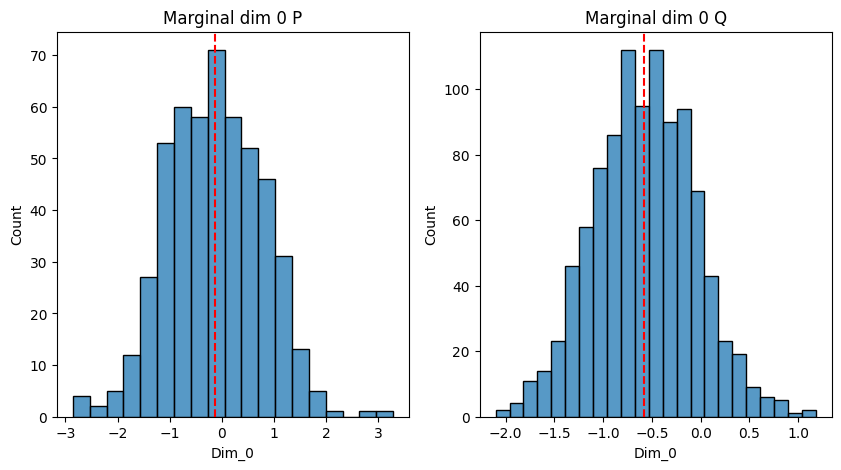

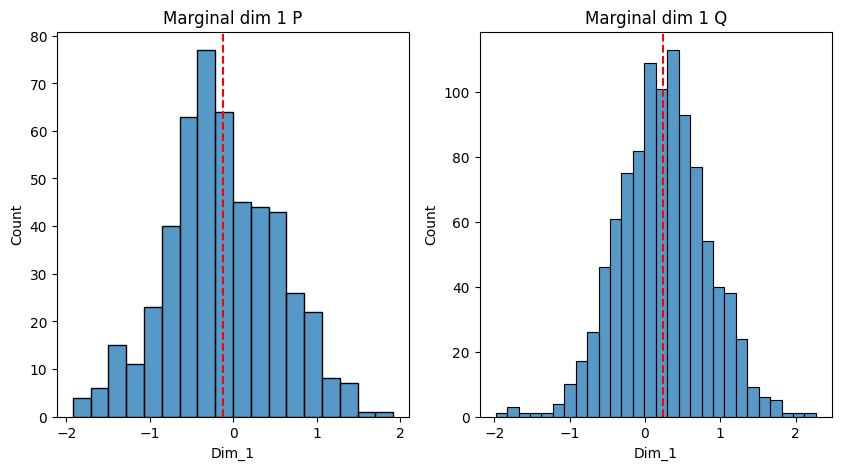

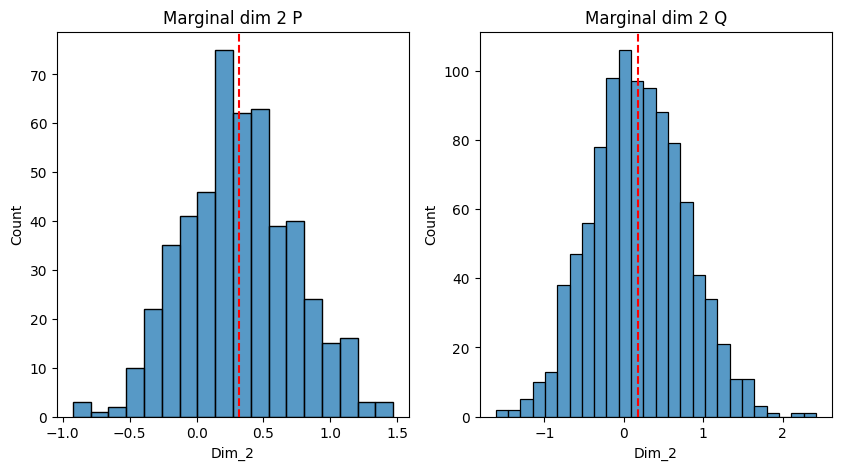

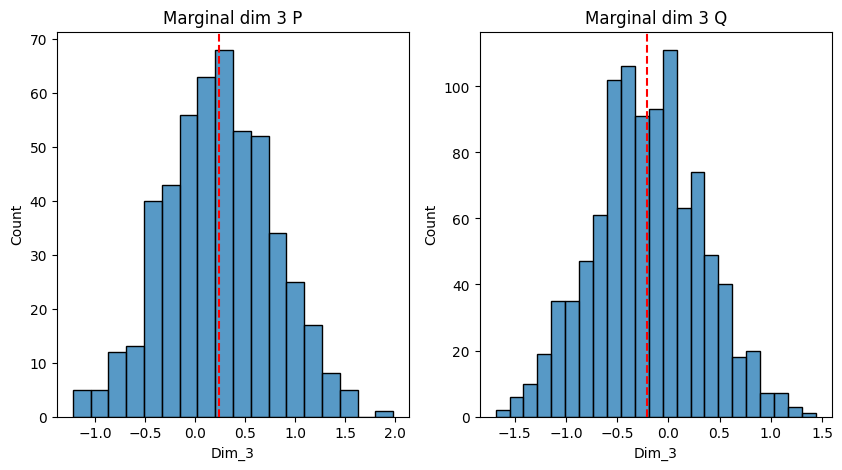

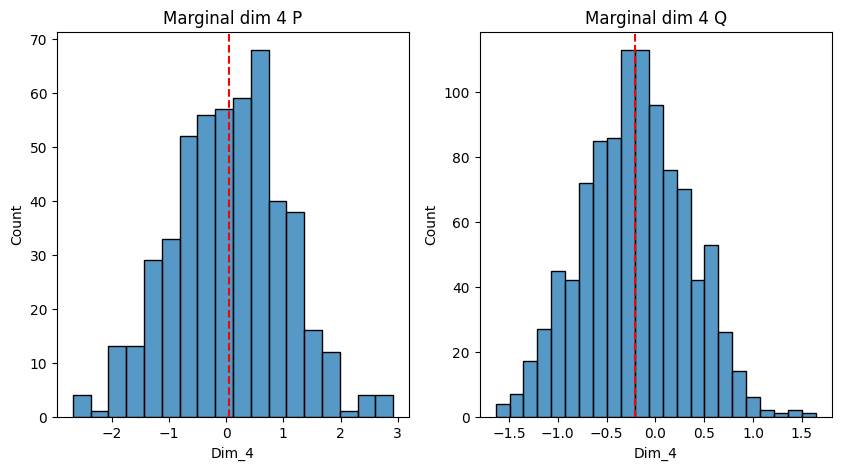

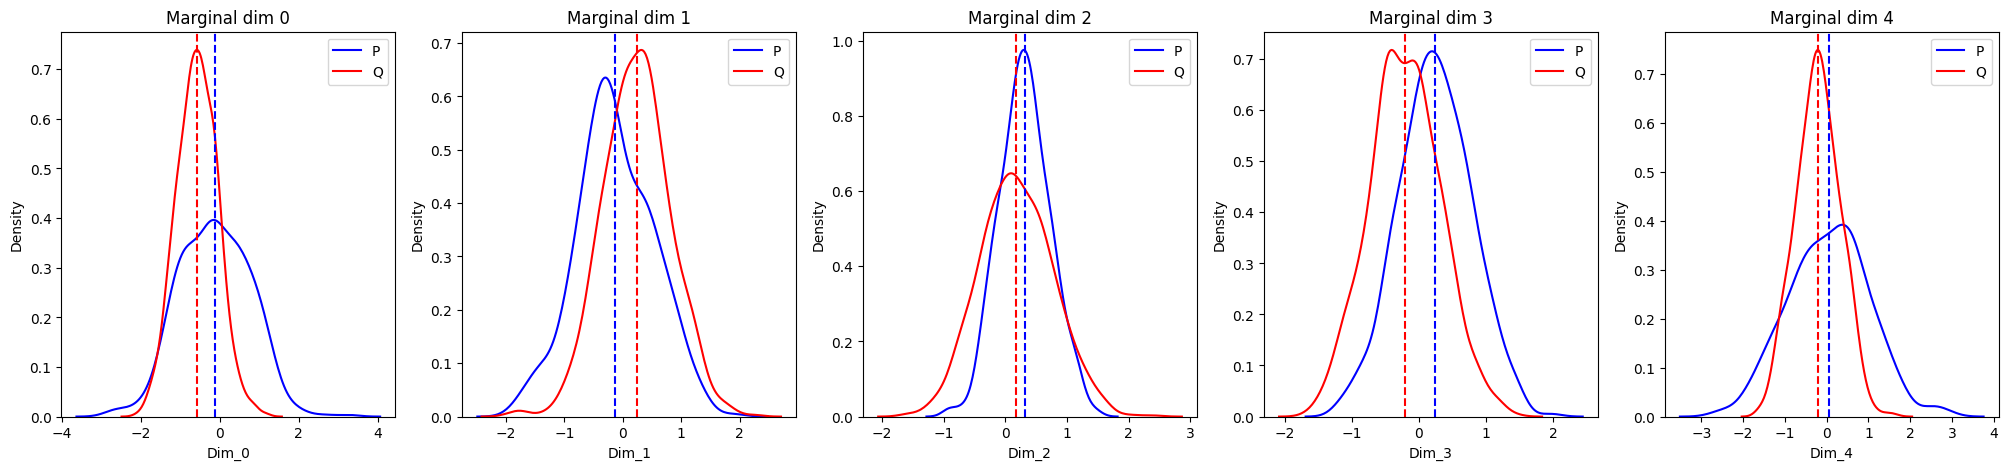

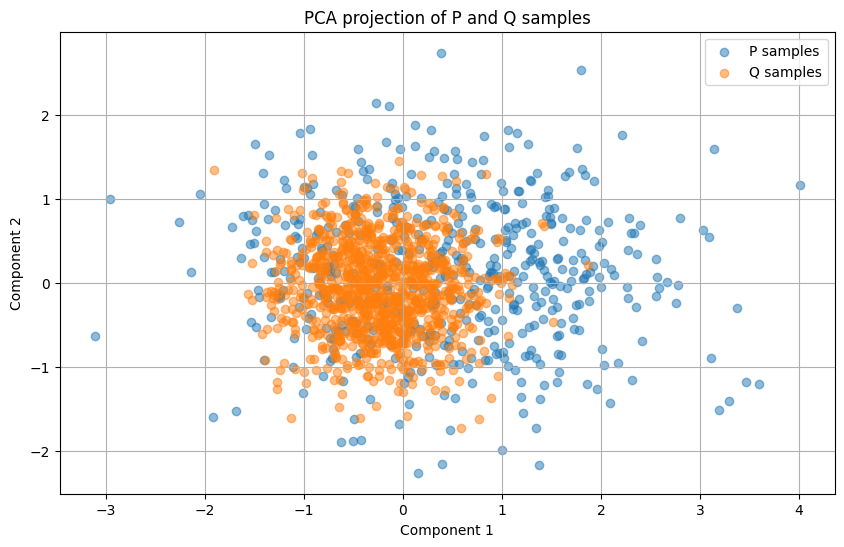

C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Evaluation\CompareModels.py:188: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  batch_metrics_std[key1] = torch.std(torch.tensor([metric[key1] for metric in batch_metrics]))
C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Evaluation\CompareModels.py:183: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  batch_metrics_std[key1][key2] = torch.std(torch.tensor([metric[key1][key2] for metric in batch_metrics]))
C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Eva

([{'Wasserstein_distance with metric euclidean': 1.108219027519226,
   'KLD_Gaussian': 2.904352903366089,
   'mean_stats': {'absolute_mean_diff': tensor(0.3291),
    'squared_mean_diff': tensor(0.1230),
    'P_mean': tensor([-0.1282, -0.1267,  0.3163,  0.2430,  0.0465]),
    'Q_mean': tensor([-0.5769,  0.2350,  0.1824, -0.2046, -0.2073])},
   'std_stats': {'absolute_std_diff': tensor(0.2177),
    'squared_std_diff': tensor(0.0750),
    'P_std': tensor([0.8993, 0.6564, 0.4091, 0.5387, 0.9654]),
    'Q_std': tensor([0.5168, 0.5794, 0.5916, 0.5273, 0.5303])},
   'q_025_stats': {'absolute_q_025_diff': tensor(0.4500),
    'squared_q_025_diff': tensor(0.2282),
    'P_q_025': tensor([-1.7390, -1.4467, -0.4067, -0.8318, -1.8162]),
    'Q_q_025': tensor([-1.5762, -0.8688, -0.9130, -1.2299, -1.2114])},
   'q_075_stats': {'absolute_q_075_diff': tensor(0.5691),
    'squared_q_075_diff': tensor(0.4597),
    'P_q_075': tensor([1.4221, 1.1221, 1.1445, 1.2768, 1.8149]),
    'Q_q_075': tensor([0.4256, 

In [ ]:
comparison_model2.compare_sample_metrics_batch(test_batch["x"][:1], test_batch["y"][:1])

In [ ]:
from PFNExperiments.LinearRegression.Evaluation.CompareComparisonModels import CompareComparisonModels

In [ ]:
comparison_model_comparer = CompareComparisonModels(
    comparison_model_1=vi,
    comparison_model_2=hmc_sampler,
    n_samples_comparison_model_1=1000,
    n_samples_comparison_model_2=500
)

c:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\.conda\lib\site-packages\pyro\util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'beta_var'}
  warnings.warn(
c:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\.conda\lib\site-packages\pyro\util.py:303: UserWarning: Found vars in model but not guide: {'tau'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")


..........


Sample: 100%|██████████| 1000/1000 [06:25,  2.59it/s, step size=8.32e-03, acc. prob=0.915]


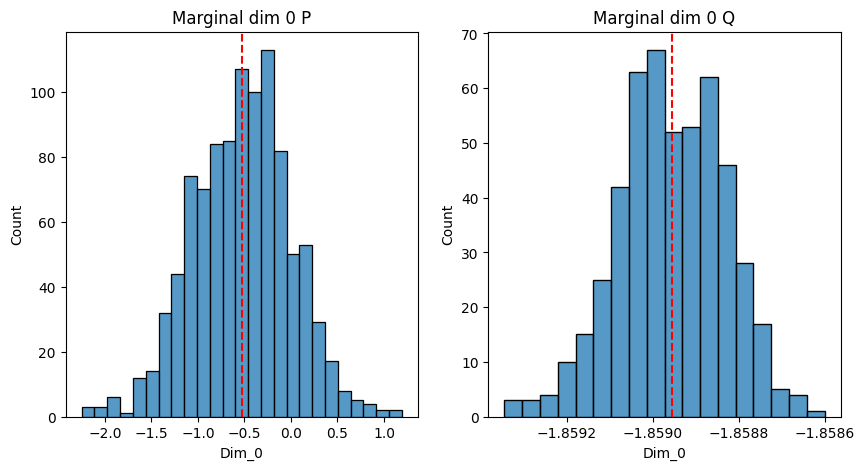

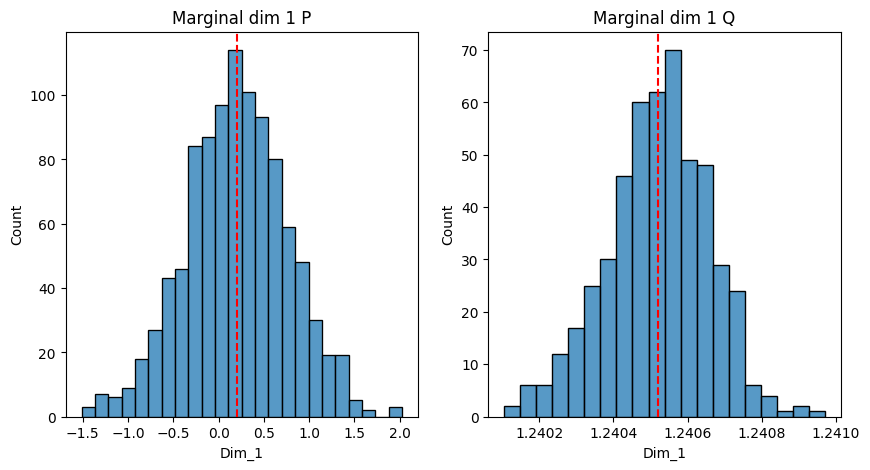

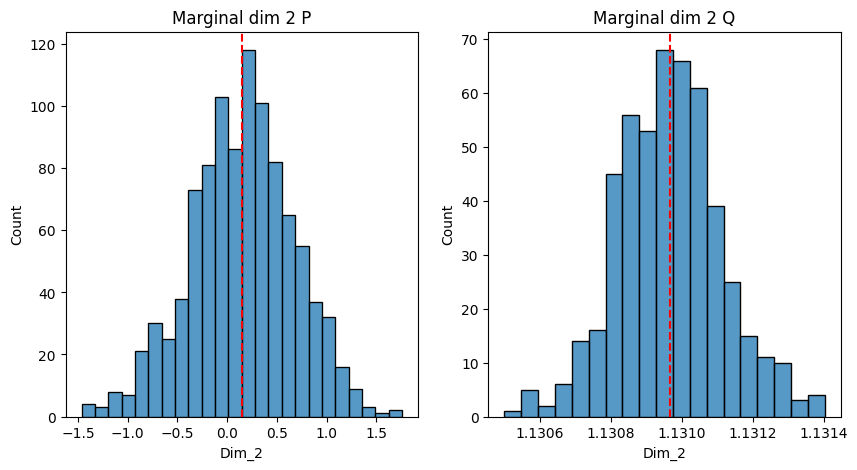

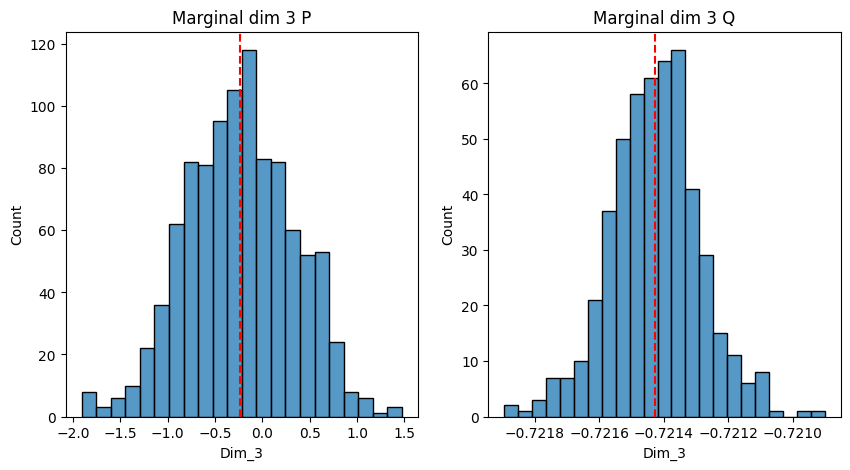

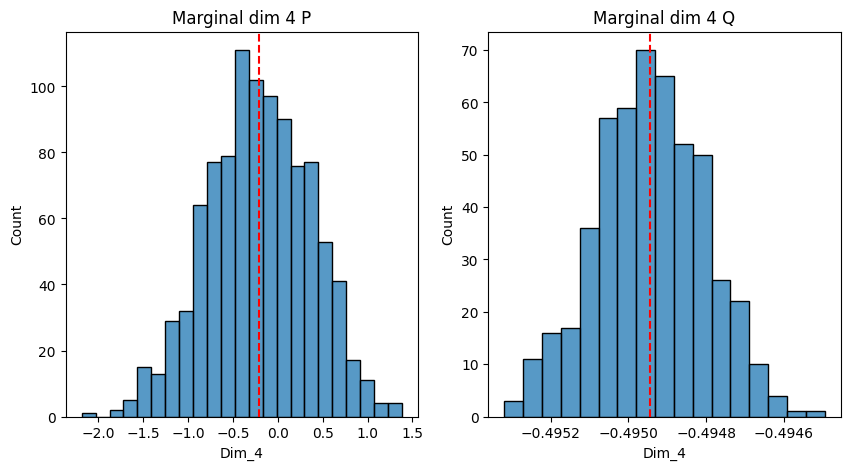

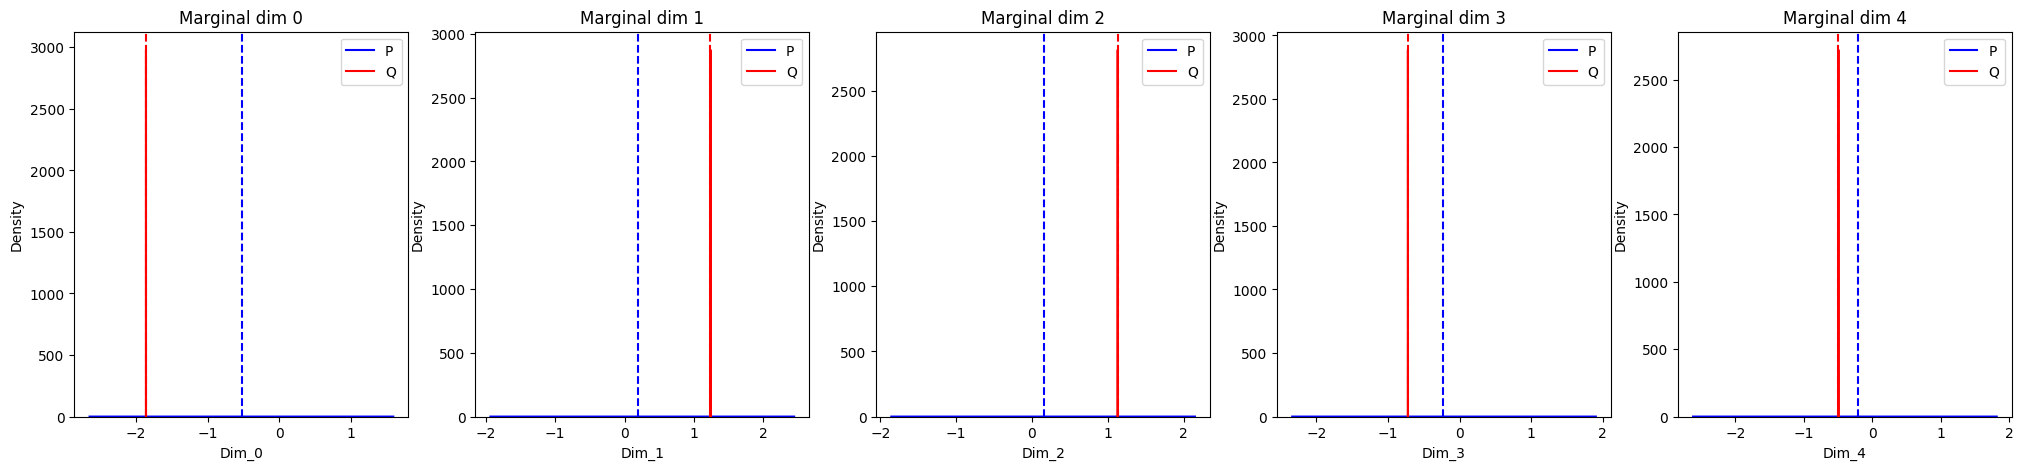

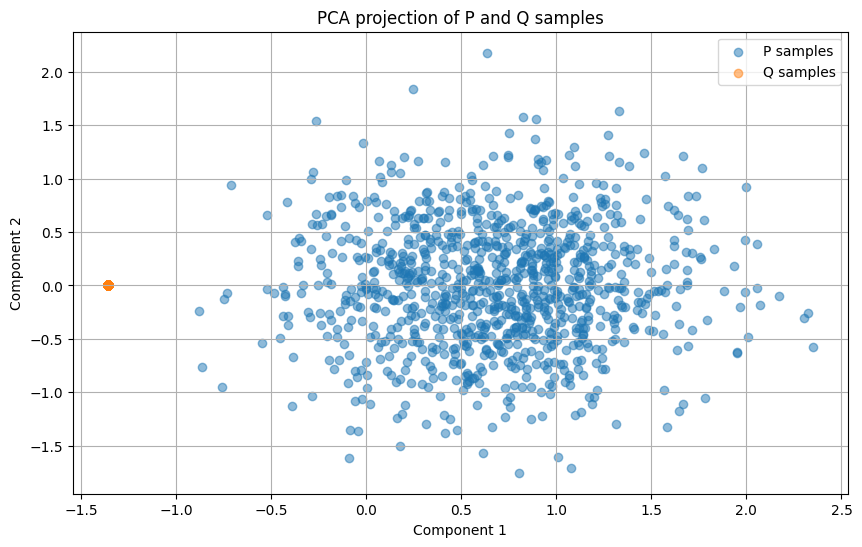

C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Evaluation\CompareComparisonModels.py:144: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  batch_metrics_std[key1] = torch.std(torch.tensor([metric[key1] for metric in batch_metrics]))
C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\LinearRegression\Evaluation\CompareComparisonModels.py:139: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at ..\aten\src\ATen\native\ReduceOps.cpp:1760.)
  batch_metrics_std[key1][key2] = torch.std(torch.tensor([metric[key1][key2] for metric in batch_metrics]))
C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\

([{'Wasserstein_distance with metric euclidean': 2.324335813522339,
   'KLD_Gaussian': 230010576.0,
   'mean_stats': {'absolute_mean_diff': tensor(0.8251),
    'squared_mean_diff': tensor(0.8278),
    'P_mean': tensor([-0.5252,  0.1994,  0.1527, -0.2334, -0.2104]),
    'Q_mean': tensor([-1.8590,  1.2405,  1.1310, -0.7214, -0.4949])},
   'std_stats': {'absolute_std_diff': tensor(0.5497),
    'squared_std_diff': tensor(0.3027),
    'P_std': tensor([0.5258, 0.5600, 0.5213, 0.5687, 0.5733]),
    'Q_std': tensor([0.0001, 0.0001, 0.0001, 0.0001, 0.0001])},
   'q_025_stats': {'absolute_q_025_diff': tensor(1.1960),
    'squared_q_025_diff': tensor(2.0037),
    'P_q_025': tensor([-1.5370, -0.9222, -0.9032, -1.3221, -1.3562]),
    'Q_q_025': tensor([-1.8592,  1.2402,  1.1307, -0.7217, -0.4952])},
   'q_075_stats': {'absolute_q_075_diff': tensor(1.0546),
    'squared_q_075_diff': tensor(1.9108),
    'P_q_075': tensor([0.4681, 1.3118, 1.1276, 0.7941, 0.8615]),
    'Q_q_075': tensor([-1.8587,  1.24

In [ ]:
comparison_model_comparer.compare_sample_metrics_batch(test_batch["x"][:1], test_batch["y"][:1])